In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('./dataset/raw_data.csv')
print(dataset.columns)
print(dataset.shape)
print(dataset.describe())

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')
(24783, 7)
         Unnamed: 0         count   hate_speech  offensive_language  \
count  24783.000000  24783.000000  24783.000000        24783.000000   
mean   12681.192027      3.243473      0.280515            2.413711   
std     7299.553863      0.883060      0.631851            1.399459   
min        0.000000      3.000000      0.000000            0.000000   
25%     6372.500000      3.000000      0.000000            2.000000   
50%    12703.000000      3.000000      0.000000            3.000000   
75%    18995.500000      3.000000      0.000000            3.000000   
max    25296.000000      9.000000      7.000000            9.000000   

            neither         class  
count  24783.000000  24783.000000  
mean       0.549247      1.110277  
std        1.113299      0.462089  
min        0.000000      0.000000  
25%        0.000000      1.000000  
50%    

Index(['label', 'tweet'], dtype='object')


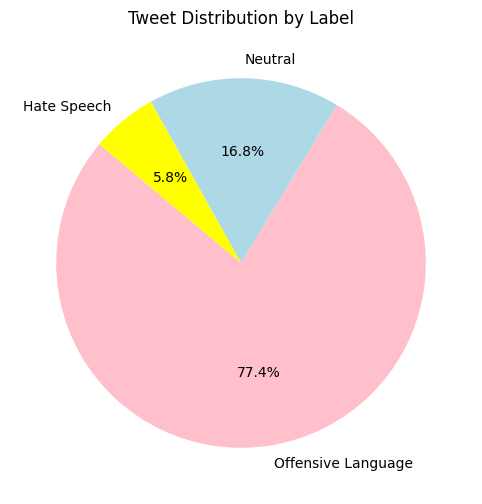

Hate speech: 1430
Offensive language: 19190


<Figure size 640x480 with 0 Axes>

In [3]:
# Keep only class and tweet columns
dataset = dataset[['class', 'tweet']].copy()
dataset.rename(columns={'class':'label'}, inplace=True)
print(dataset.columns)

# basic stats
hate = dataset[dataset['label'] == 0]
offensive = dataset[dataset['label'] == 1]
netural = dataset[dataset['label'] == 2]

# plot class distribution
import matplotlib.pyplot as plt

label_map = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neutral'}
dataset['label_category'] = dataset['label'].map(label_map)
label_counts = dataset['label_category'].value_counts()
colors = ['pink', 'lightblue', 'yellow']

fig = plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Tweet Distribution by Label')
plt.show()

plt.savefig('./img/label_distribution.png', bbox_inches='tight')



# Drop rows with missing values and class as 2 which is neither hate speech nor offensive language
dataset.dropna(inplace=True)
dataset = dataset[dataset['label'] != 2]

hate = dataset[dataset['label'] == 0]
print("Hate speech: " + str(len(hate)))
offensive = dataset[dataset['label'] == 1]
print("Offensive language: "+ str(len(offensive)))

# Tweet Cleaning


- Text Cleaning: While BERTweet can handle a variety of Twitter-specific text features, ensuring the text is free from HTML entities, excessive whitespace, or corrupted text (like broken encodings) is helpful.
- Normalization: Convert the text into a consistent format (like lowercasing), although BERTweet is robust enough to handle case variations due to its cased training.
- Handling of Special Elements:
  - Mentions: It’s usually left as is because mentions are common in Twitter data and BERTweet is trained to understand them.
  - Hashtags: These should be retained as BERTweet can extract meaning from them.
  - URLs: Often replaced with a placeholder like "HTTPURL". BERTweet is trained to recognize these placeholders.
  - Emojis: Leave emojis as they are since BERTweet is trained to understand their context within tweets.
  - HTML entities: Before feeding text into BERTweet, it is recommended to convert HTML entities into their corresponding Unicode characters. This ensures the text is in a form that the model understands and can analyze accurately. This conversion can be handled as described using the html.unescape() function in Python, which turns HTML entities into readable text or emojis.


In [4]:
# Tweet Cleaning
import re
import html

def clean_text(df, text_field):
    """
    Accepts a DataFrame and a text field, then:
    1) Reduces multiple whitespaces to a single instance
    1) Replaces URLs with 'URLHERE'
    3) Replaces mentions with 'MENTIONHERE'
    4) Covert HTML entities
    5) Converts text to lowercase 
    This standardizes counts of URLs and mentions
    without caring about specific people mentioned.
    """

    space_pattern = r'\s+'
    giant_url_regex = (r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                       r'[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    # mention_regex = r'@[\w\-]+'
    # html_entity_regex = r'&[#]?[a-zA-Z0-9]+;'
    df[text_field] = df[text_field].apply(lambda text: re.sub(space_pattern, ' ', text))
    df[text_field] = df[text_field].apply(lambda text: re.sub(giant_url_regex, 'HTTPURL', text))
    # df[text_field] = df[text_field].apply(lambda text: re.sub(mention_regex, 'MENTIONHERE', text))
    # df[text_field] = df[text_field].apply(lambda text: re.sub(html_entity_regex, '', text))
    df[text_field] = df[text_field].apply(lambda text: text.lower())
    df[text_field] = df[text_field].apply(html.unescape)
    return df

data_clean = clean_text(dataset, 'tweet')

data_clean.to_csv('./dataset/cleaned_dataset.csv', index=False)

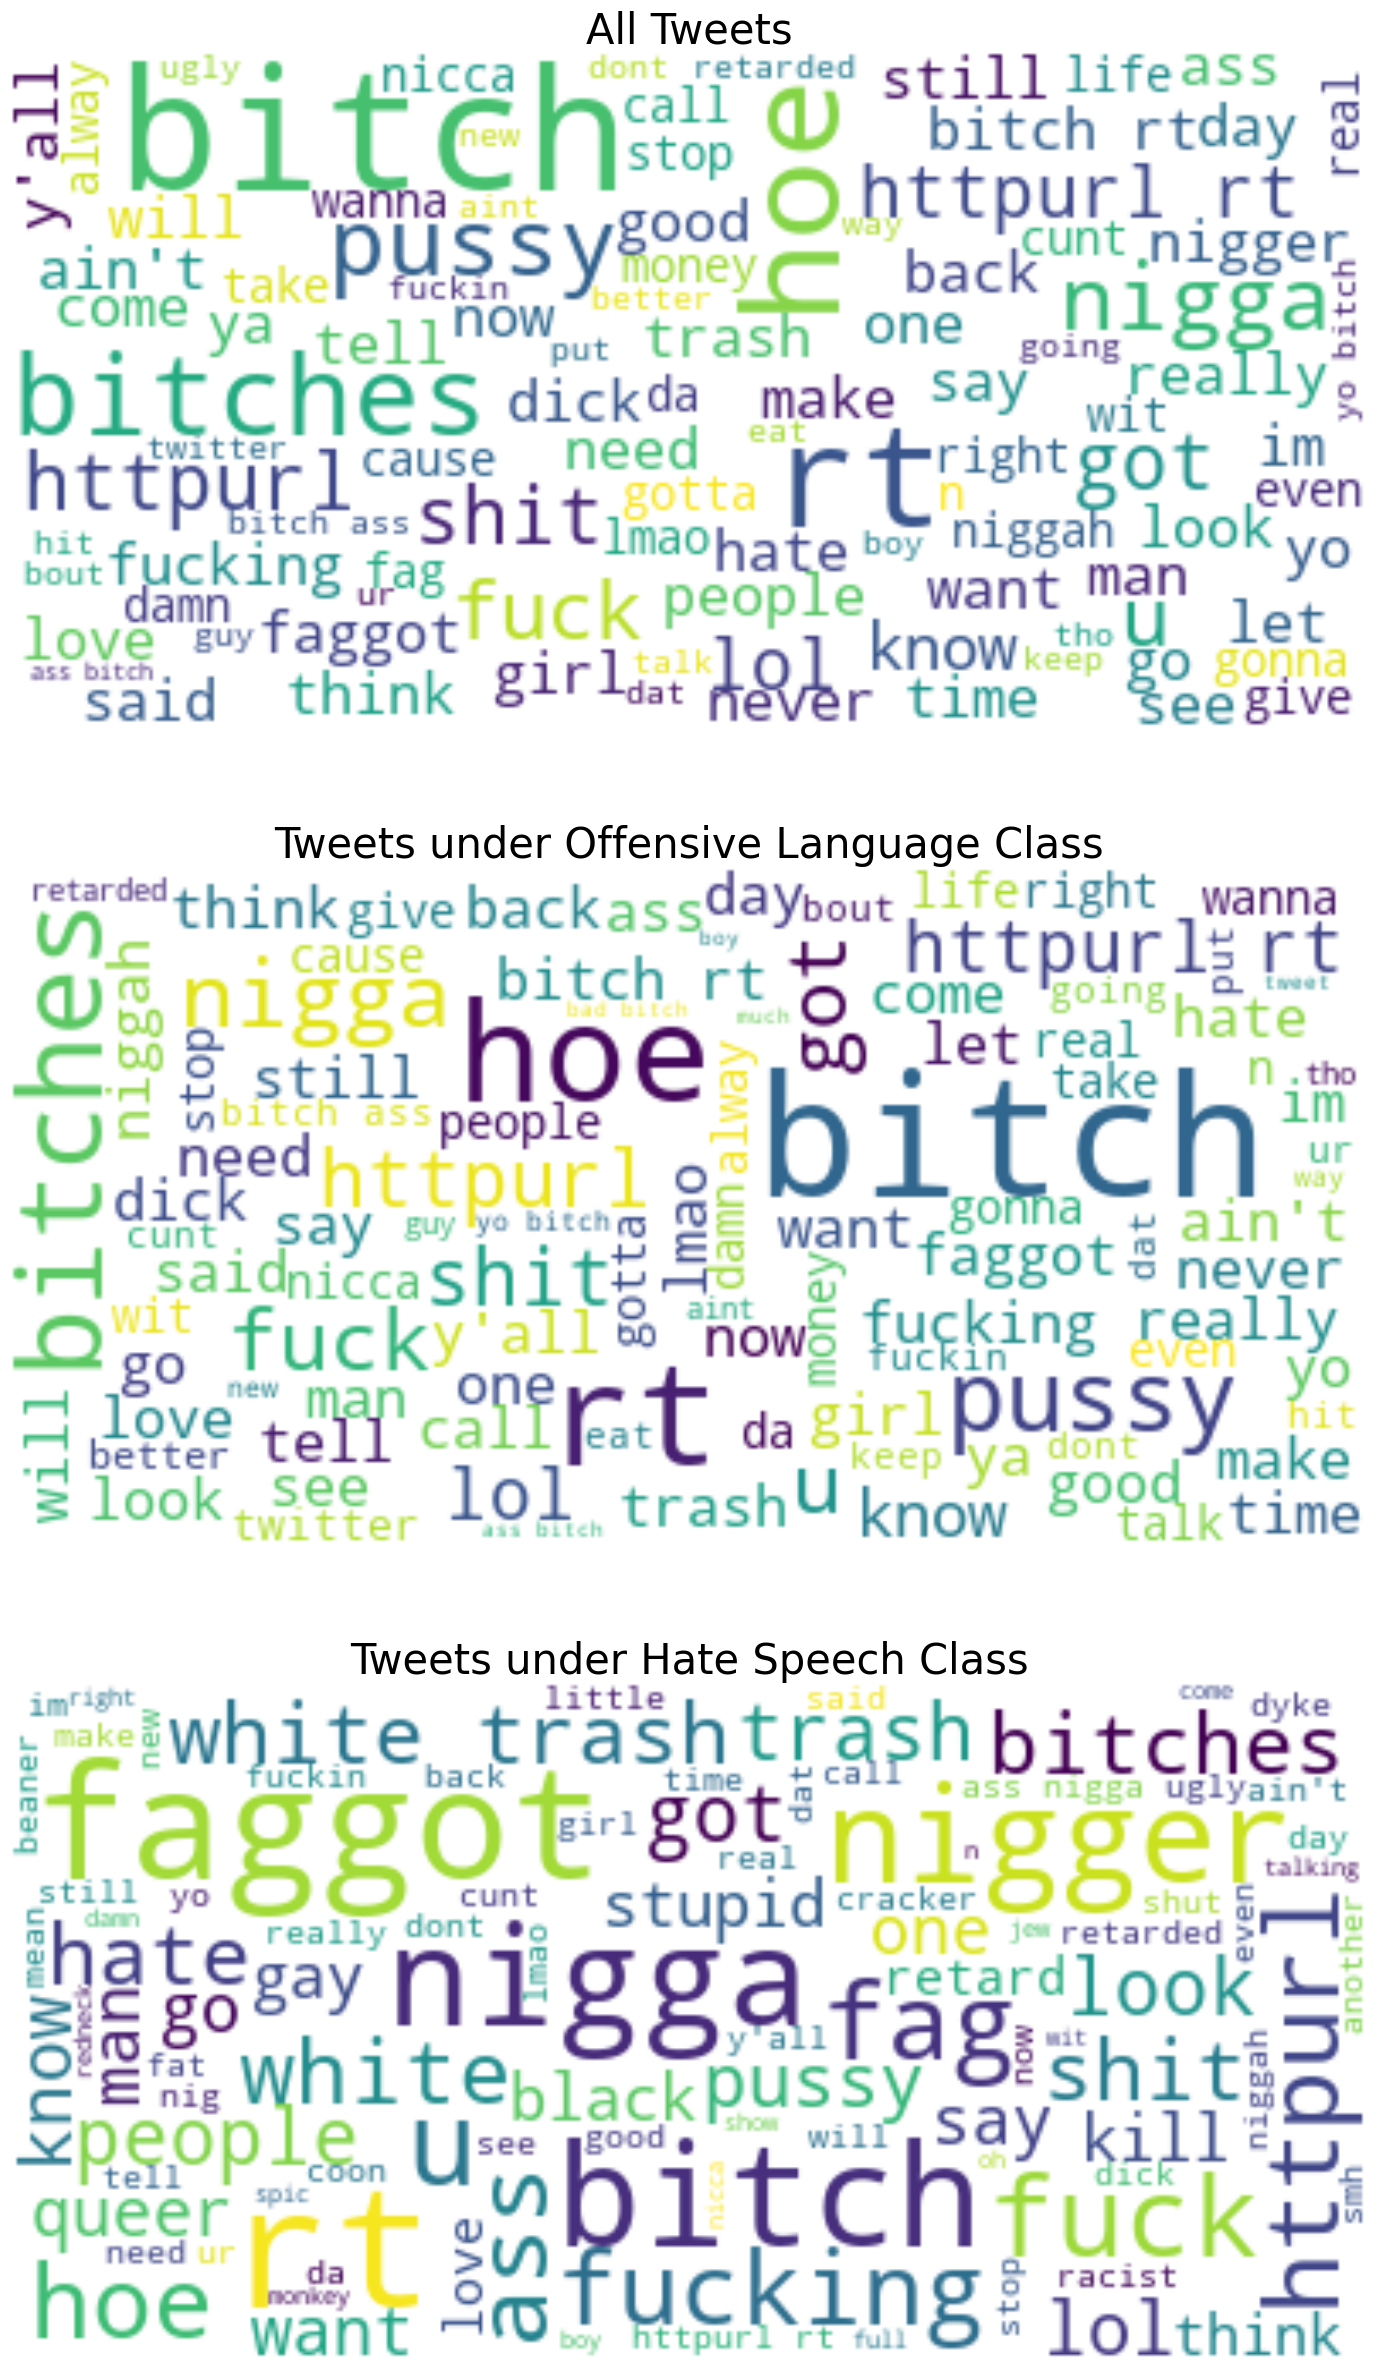

In [6]:
# Data visaualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os 

df_offensive = data_clean[data_clean['label'] == 1]
df_hate = data_clean[data_clean['label'] == 0]
tweet_all = " ".join(x for x in data_clean.tweet)
tweet_offensive = " ".join(x for x in df_offensive.tweet)
tweet_hate = " ".join(x for x in df_hate.tweet)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_all)
wordcloud_offensive = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_offensive)
wordcloud_hate = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_hate)

# Display the images
ax[0].imshow(wordcloud_all, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_offensive, interpolation='bilinear')
ax[1].set_title('Tweets under Offensive Language Class',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_hate, interpolation='bilinear')
ax[2].set_title('Tweets under Hate Speech Class',fontsize=30)
ax[2].axis('off')

if not os.path.exists("img"):
    os.makedirs("img")
wordcloud_all.to_file("img/wordcloud_all.png")
wordcloud_offensive.to_file("img/wordcloud_offensive.png")
wordcloud_hate.to_file("img/wordcloud_hate.png")


